#Text Classification using Attention Mechanism in Keras

Nov 25 2018

With all the hype around attention, I realized there were far too few decent guides on how to get started. With that in mind, I present to you the “Hello World” of attention models: building text classification models in Keras that use an attention mechanism

## Step 1: Preparing the Dataset

For this guide we’ll use the standard [IMDB dataset](https://www.imdb.com/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/) (basically Jeff Bezos’ Rotten Tomatoes competitor). The IMDB dataset usually comes pre-packaged with Keras. If we download it this way we will get a version that has already been preprocessed such that the sequences of words have been converted to sequences of integers, where each integer represents a specific word in a dictionary. However for our purposes, we’re going to take data directly from a CSV file of unprocessed reviews.

In [ ]:
from importlib import reload
import sys
from imp import reload
import warnings
warnings.filterwarnings('ignore')
if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!unzip word2vec-nlp-tutorial.zip
!unzip imdb_master.csv.zip
!unzip labeledTrainData.tsv.zip
!unzip testData.tsv.zip
!unzip unlabeledTrainData.tsv.zip

Archive:  word2vec-nlp-tutorial.zip
  inflating: labeledTrainData.tsv.zip  
  inflating: sampleSubmission.csv    
  inflating: testData.tsv.zip        
  inflating: unlabeledTrainData.tsv.zip  
Archive:  imdb_master.csv.zip
  inflating: imdb_master.csv         
Archive:  labeledTrainData.tsv.zip
  inflating: labeledTrainData.tsv    
Archive:  testData.tsv.zip
  inflating: testData.tsv            
Archive:  unlabeledTrainData.tsv.zip
  inflating: unlabeledTrainData.tsv  


It’s rarely the case that we get preprocessed numerical sequences representing text data. As such, we should pay attention to how our text is converted to the numbers that our attention model can understand.

For our raw text, we need to do some filtering before our model-building. In addition to filtering out punctuation characters, we also want to make everything lowercase. We also want to reduce words to just their root (e.g., so words like “jump” and “jumping” aren’t given widely different encodings).

In [ ]:
import pandas as pd

df1 = pd.read_csv('labeledTrainData.tsv', delimiter="\t")
df1 = df1.drop(['id'], axis=1)
df2 = pd.read_csv('imdb_master.csv',encoding="latin-1")
df2 = df2.drop(['Unnamed: 0','type','file'],axis=1)
df2.columns = ["review","sentiment"]
df2 = df2[df2.sentiment != 'unsup']
df2['sentiment'] = df2['sentiment'].map({'pos': 1, 'neg': 0})
df = pd.concat([df1, df2]).reset_index(drop=True)

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))
df.head()

|   |                                            review | sentiment |                                 Processed_Reviews |
|---|--------------------------------------------------:|----------:|--------------------------------------------------:|
| 0 | With all this stuff going down at the moment w... |         1 | stuff go moment mj ive start listen music watc... |
| 1 | \The Classic War of the Worlds\" by Timothy Hi... |         1 | classic war world timothy hines entertain film... |
| 2 | The film starts with a manager (Nicholas Bell)... |         0 | film start manager nicholas bell give welcome ... |
| 3 | It must be assumed that those who praised this... |         0 | must assume praise film greatest film opera ev... |
| 4 | Superbly trashy and wondrously unpretentious 8... |         1 | superbly trashy wondrously unpretentious 80 ex... |

If you’ve done coding challenges with strings outside of machine learning, you can probably see just how much easier this makes our task. Beyond just processing and encoding words, we also want to make sure our sequences are properly padded. In other words, we want to set a pre-defined size for our model’s inputs (the same model that is going to be fed sentences of variable length). For our purposes, our padding method will involve filling in a sentence with empty indicators if our review is too short, and cutting off a sentence if it is too long. One good way of doing this is to use the mean sequence length.

In [ ]:
df.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean()

128.51009333333334

The built-in `pad_sequences()` function takes care padding sequences. All that's needed now is the `MAX_LEN` argument which will determine the length of the output arrays. As mentione before, if sentences are shorter than this length, they will be padded. If they are longer than this value, they will be trimmed.

In [ ]:
MAX_FEATURES = 6000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])

RNN_CELL_SIZE = 32

MAX_LEN = 130   # Since our mean length is 128.5
X_train = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y_train = df['sentiment']

## Step 2: Creating the Attention Layer

Our use of an attention layer solves a conundrum with using RNNs. We can easily use the final encoded state of a recurrent neural network for a prediction task. However, given the tendency of RNNs to forget relevant information in the previous steps of the sequence, this could lose some of the useful information encoded there. In order to keep that information, we can use an average of the encoded states the RNN outputs. Since all these encoded states of the RNN are equally valuable, we use a weighted sum of these encoded states (i.e., our Attention mechanism) to make our prediction.

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

If this concept of using a weighted sum of a bunch of encodings sounds familiar, it should. We’re computing these attention weights simply by building a small fully connected neural network on top of each encoded state. This network will have a single-unit final output layer that will correspond to the attention weight we will assign.

![An overview of the specific attention mechanism that we're using, which is additive attention](https://matthewmcateer.me/static/9537559ff955ff1ceeb31c96cb611fe8/aa619/additive_attention.webp)

Attention function is very simple, it’s just dense layers back to back softmax. so basically a three-layer neural network density.

Our Attention function is very simple, just dense layers back to back plus a tanh function. Of course, Attention is used in many applications in NLP (and beyond). There are plenty of other more specialized types. [Lilian Weng](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) gave a very concise overview of the histories and different types of attention out there (summarized in the table below):

| **Name**                | **Alignment score function**                                                                                                                                                                                                                    | **Citation**     | **Notes**                                                                                                                                                               |
|-------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Content-based attention | $\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \text{cosine}[\boldsymbol{s}_t, \boldsymbol{h}_i]$                                                                                                                                          | [Graves2014](https://arxiv.org/abs/1410.5401)   |                                                                                                                                                                         |
| Additive                | $\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \mathbf{v}_a^\top \tanh(\mathbf{W}_a[\boldsymbol{s}_t; \boldsymbol{h}_i])$                                                                                                                  | [Bahdanau2015](https://arxiv.org/pdf/1409.0473.pdf) | Referred to as "concat" in Luong, et al., 2015 and as "additive attention" in Vaswani, et al., 2017                                                                     |
| Location- Based         | $\alpha_{t,i} = \text{softmax}(\mathbf{W}_a \boldsymbol{s}_t)$ Note: This simplifies the softmax alignment to only depend on the target position.                                                                                               | [Luong2015](https://arxiv.org/pdf/1508.04025.pdf)    |                                                                                                                                                                         |
| General                 | $\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \boldsymbol{s}_t^\top\mathbf{W}_a\boldsymbol{h}_i$ where $W_a$ is a trainable weight matrix in the attention layer.                                                                         | [Luong2015](https://arxiv.org/pdf/1508.04025.pdf)    |                                                                                                                                                                         |
| Dot-Product             | $\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \boldsymbol{s}_t^\top\boldsymbol{h}_i$                                                                                                                                                      | [Luong2015](https://arxiv.org/pdf/1508.4025.pdf)    |                                                                                                                                                                         |
| Scaled Dot- Product     | $\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \frac{\boldsymbol{s}_t^\top\boldsymbol{h}_i}{\sqrt{n}}$ Very similar to the dot-product attention except for a scaling factor; where $n$ is the dimension of the source hidden state. | [Vaswani2017](http://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf)  | It adds a scaling factor $1/\sqrt{n}$, motivated by the concern when the input is large, the softmax function may have an extremely small gradient, hard for efficient learning. |

But for now, all we need is the simple attention layer that's little more than a 3-layer multi-layer-perceptron (i.e., Bahdanau Attetnion).


## Step 3: The `Embedding` Layer

Neural networks are the composition of operators from linear algebra and non-linear activation functions. In order to perform these computations on our input sentences, we must first embed them as a vector of numbers. There are three main approaches to perform this embedding pre-trained embeddings like [Word2Vec](https://render.githubusercontent.com/view/ipynb??) or [GloVe](https://render.githubusercontent.com/view/ipynb??) or randomly initializing. For the sake of simplicity, we're going to stick with random initialization.
  
To perform this embedding we use the `Embedding` function from the layers package. The parameters of this matrix will then be trained with the rest of the graph.

In [ ]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Step 4: Our Bi-directional RNN

We will be using a bi-directional RNN instead of a vanilla unidirectional RNN. Despite the fancy name this is simply the concatentation of two RNNs. One RNN processes the sequence from left to right (the "forward" RNN), while the other processes the sequence from right to left (the "backward" RNN). By using both directions, we get a more reliable encoding as each word can be given the context of its neighbors on both sides (rather than just earlier in the sequence).

In [ ]:
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Since our model uses a bi-directional RNN, we first concatenate the hidden states from each RNN before computing the attention weights and applying the weighted sum.

In [ ]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector, attention_weights = Attention(10)(lstm, state_h)

# Removal of the globalMaxPool1D could be trouble
#globmax = GlobalMaxPool1D()(context_vector)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="sigmoid")(dropout)

model = keras.Model(inputs=sequence_input, outputs=output)

The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level. We can easily print out a list of our layers in Keras.

In [ ]:
# summarize layers
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 130, 128)     768000      input_1[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 130, 64)      41216       embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 130, 64), (N 24832       bi_lstm_0[0][0]                  
______________________________________________________________________________________________

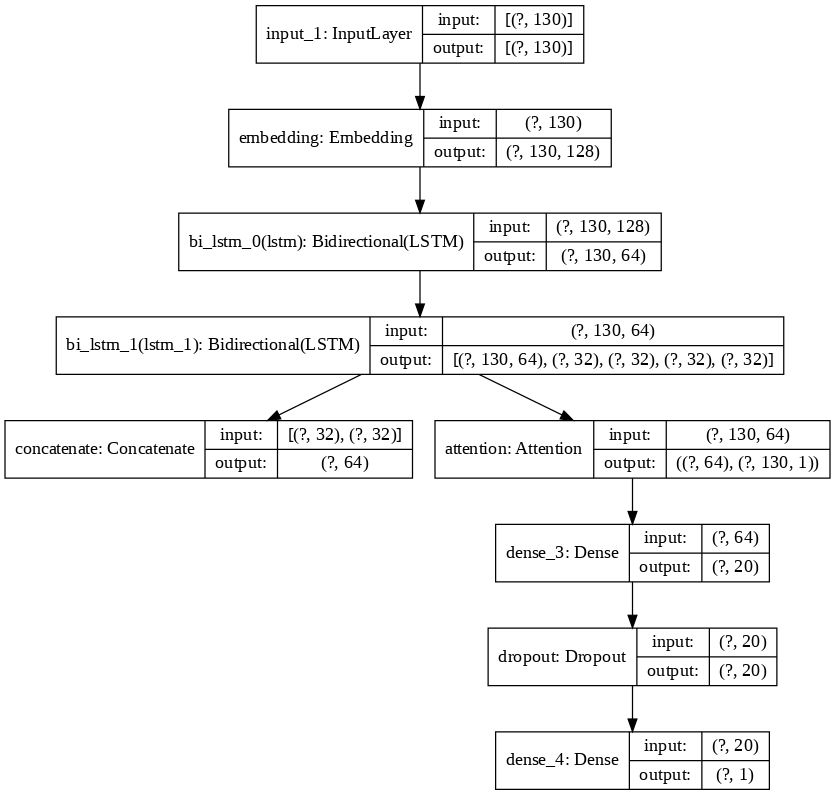

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

## Step 5: Compiling the Model

In order to actually train our model we need to give it a loss function and an optimizer. An out-of-the-box Adam optimizer will also be what we use to optimize our model. Since our model is a binary classification problem and the model outputs a probability we'll use the standard `binary_crossentropy` loss function.

Of course, we can also go beyond just accuracy and loss. Here is a comprehensive look at all the metrics we can add to our optimization criteria:
- **T.P. (True Positives)** - This is just a raw count of the number of positive items that are correctly classified as so.
- **F.P. (False Positives)** - This is the raw count of false positives.
- **T.N. (True Negatives)** - This is just a raw count of the number of positive items that are correctly classified as so.
- **F.N. (False Negatives)** - This is the raw count of false negatives.
- **Binary Accuracy** - This is a calculation of how often the predictions matches the labels (out of two possible options, `0` or `1`).
- **Precision** - This is a calculation of precision of the predictions with respect to the labels.
- **Recall** - This is a calculation of the recall of the predictions with respect to the labels.
- **AUC** - Computes the approximate AUC (Area under the curve) via a Riemann sum, all from the true positive, false positive, true negative, and false negatives above.

For the sake of model improvement, our optimizer will only focus on one of these metrics for now (namely accuracy).

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Step 6: Training the Model

We'll train our Attention model for $5$ epochs in mini-batches of $100$ samples. You read that right. Not $50$ or $250$, just $5$ is all we need. This is $5$ iterations over all samples in the `X_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the $20\%$ samples from the validation set.

In [ ]:
BATCH_SIZE = 100
EPOCHS = 5
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)

Train on 60000 samples, validate on 15000 samples
Epoch 1/5
60000/60000 [==============================] - 409s 7ms/sample - loss: 0.3186 - tp: 19882.0000 - fp: 3309.0000 - tn: 31691.0000 - fn: 5118.0000 - accuracy: 0.8595 - precision: 0.8573 - recall: 0.7953 - auc: 0.9358 - val_loss: 0.2049 - val_tp: 11501.0000 - val_fp: 214.0000 - val_tn: 2286.0000 - val_fn: 999.0000 - val_accuracy: 0.9191 - val_precision: 0.9817 - val_recall: 0.9201 - val_auc: 0.9732
Epoch 2/5
60000/60000 [==============================] - 406s 7ms/sample - loss: 0.2153 - tp: 22233.0000 - fp: 2318.0000 - tn: 32682.0000 - fn: 2767.0000 - accuracy: 0.9153 - precision: 0.9056 - recall: 0.8893 - auc: 0.9703 - val_loss: 0.1705 - val_tp: 11641.0000 - val_fp: 164.0000 - val_tn: 2336.0000 - val_fn: 859.0000 - val_accuracy: 0.9318 - val_precision: 0.9861 - val_recall: 0.9313 - val_auc: 0.9818
Epoch 3/5
60000/60000 [==============================] - 405s 7ms/sample - loss: 0.1716 - tp: 22853.0000 - fp: 1755.0000 - tn: 33245.0

## Step 7: Evaluating the Model

Our model seems to have gotten some impressive results, no less after only 5 training epochs. Let's take a closer look at our training progress and performance. Normally when collecting a training history we would be fine with just two values: Loss and accuracy. However, we went far beyond just those.

For evaluation purposes, we can generate a list of predictions on previously unseen test data (we can also use the preprocessing functions from earlier to easily convert the Test data to a usable form).

In [ ]:
# Loading the test dataset, and repeating the processing steps
df_test=pd.read_csv("testData.tsv",header=0, delimiter="\t", quoting=3)
df_test.head()
df_test["review"]=df_test.review.apply(lambda x: clean_text(x))
df_test["sentiment"] = df_test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
y_test = df_test["sentiment"]
list_sentences_test = df_test["review"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_test = pad_sequences(list_tokenized_test, maxlen=MAX_LEN)

## Making predictions on our model
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     12500
           1       0.96      0.99      0.97     12500

    accuracy                           0.97     25000
   macro avg       0.97      0.97      0.97     25000
weighted avg       0.97      0.97      0.97     25000



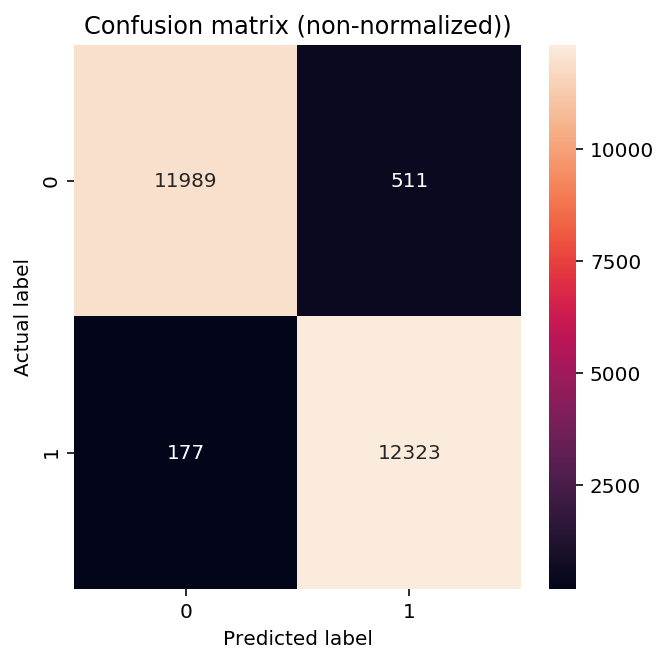

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

report = classification_report(y_test, y_pred)
print(report)


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_test, y_pred)

Overall our classifier is doing pretty well, a $97\%$ F1-score accuracy on the test dataset.

Let's take a closer look at hour our laundry-list of metrics fared over the entire training process.

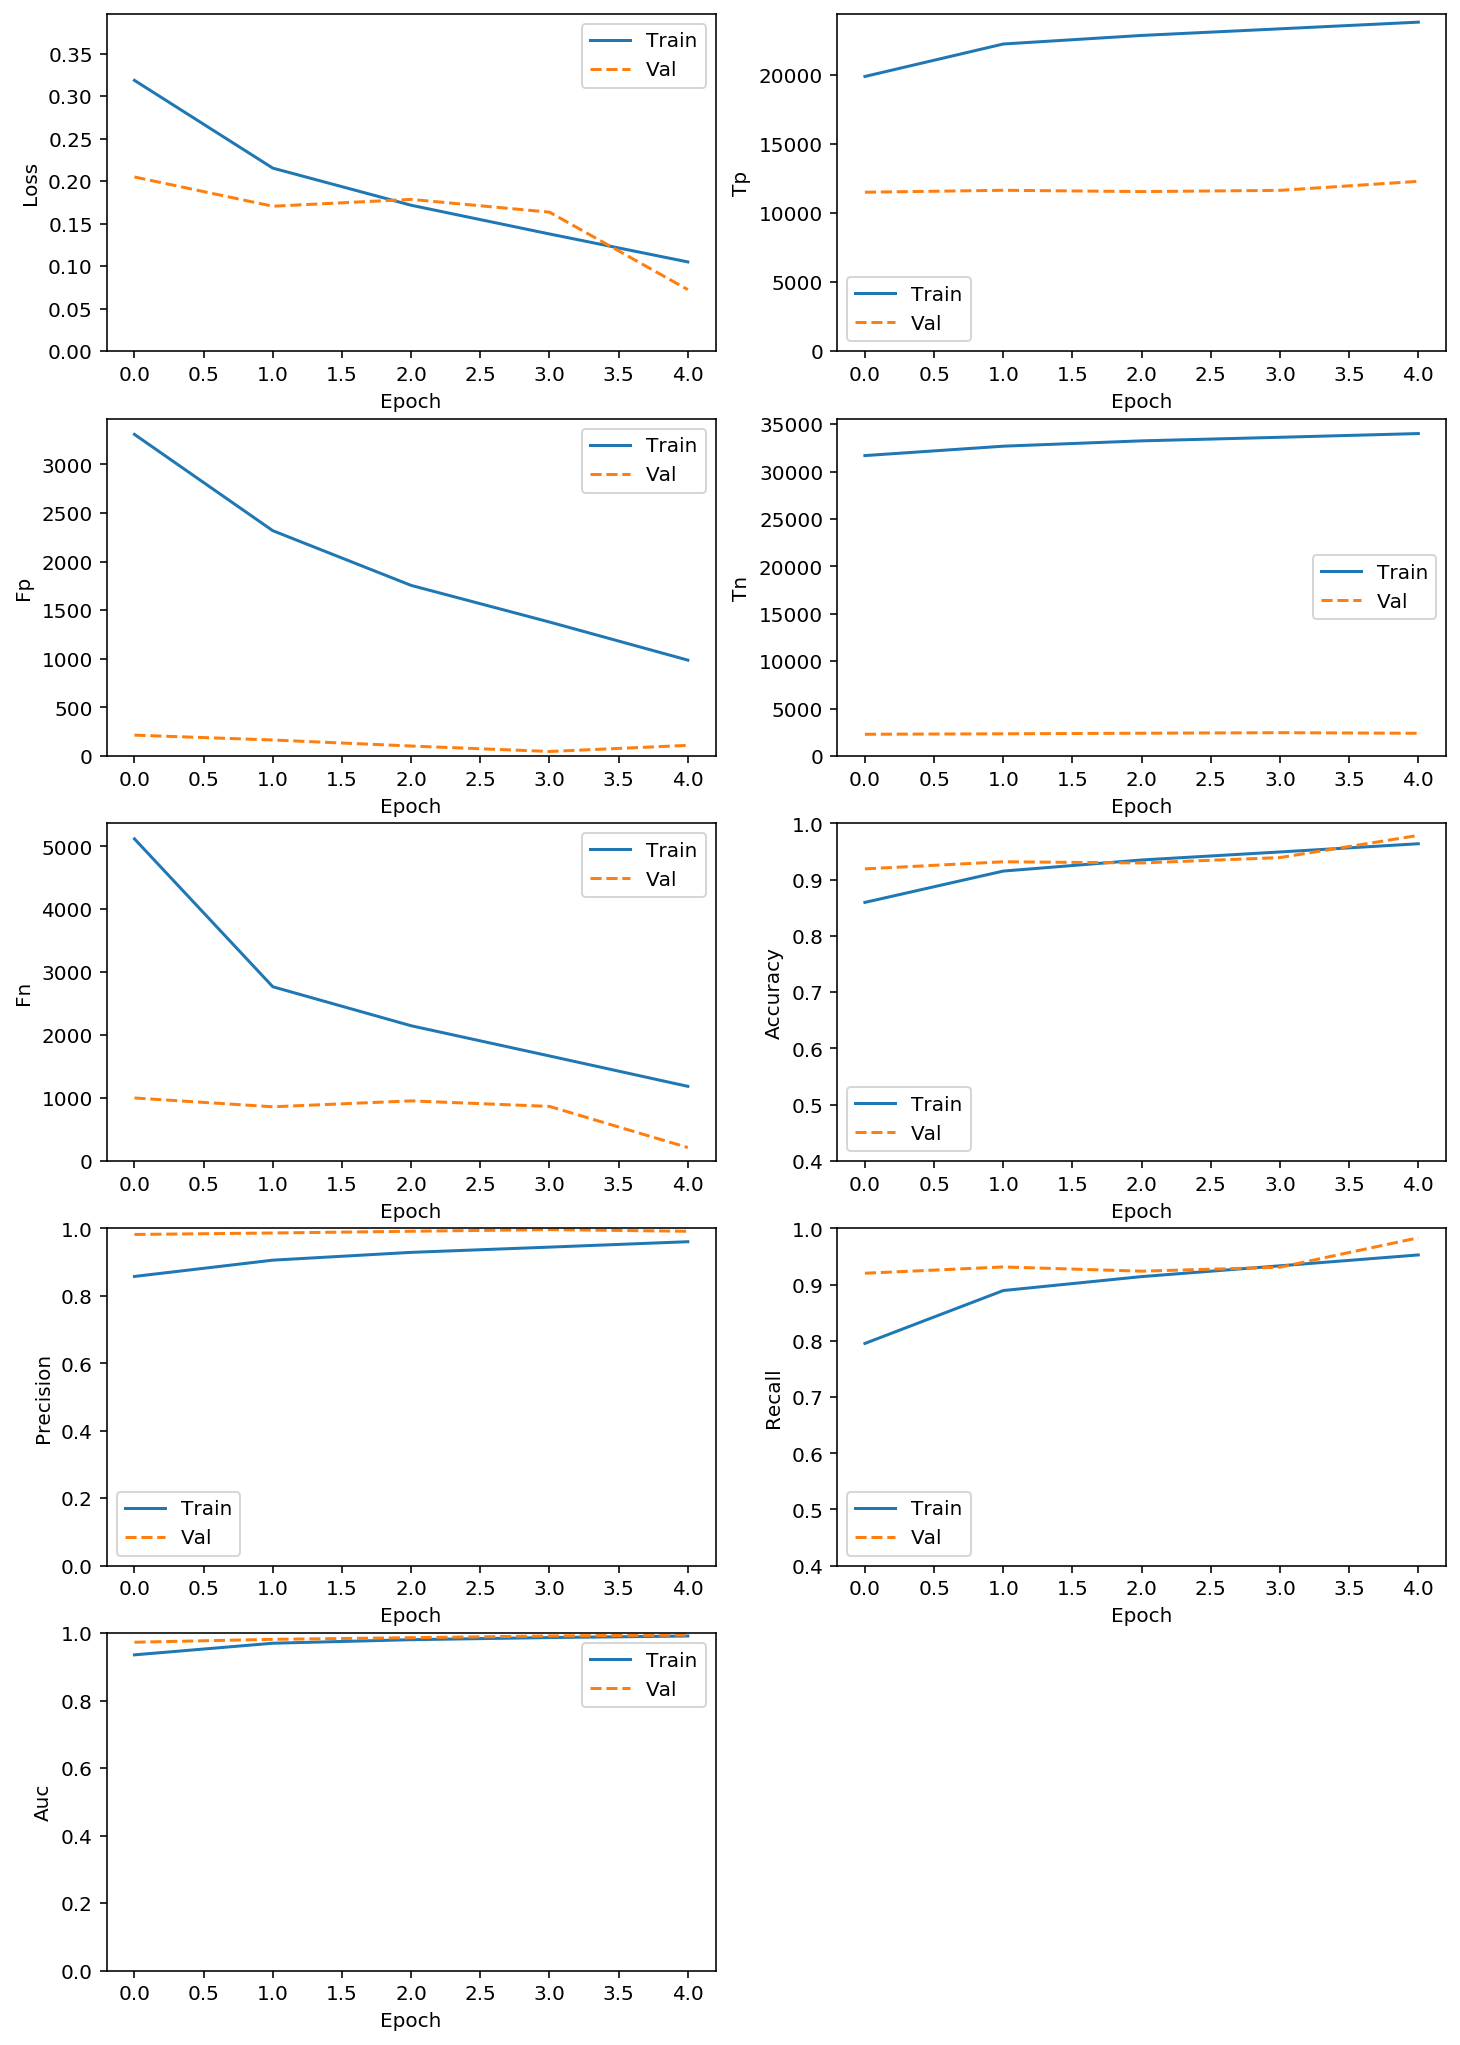

In [ ]:
#plt.style.use("fivethirtyeight")

# Cross Validation Classification Accuracy

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
mpl.rcParams["figure.figsize"] = (12, 18)

def plot_metrics(history):
    metrics = [
        "loss",
        "tp", "fp", "tn", "fn",
        "accuracy",
        "precision", "recall",
        "auc",
    ]
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(5, 2, n + 1)
        plt.plot(
            history.epoch,
            history.history[metric],
            color=colors[0],
            label="Train",
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            color=colors[1],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1] * 1.2])
        elif metric == "accuracy":
            plt.ylim([0.4, 1])
        elif metric == "fn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "fp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "precision":
            plt.ylim([0, 1])
        elif metric == "recall":
            plt.ylim([0.4, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

plot_metrics(history)

True Negatives and True Positives rise, False Postives and False Negatives fall, Accuracy and AUC steadily rise, and the Precision and Recall tend towards 1.0. This was pretty good for a first try.

We also want to be sure to calculate the Receiver Operating Characteristic (ROC) metric as another test of the classifier output quality. Plots of ROC curves usually feature the false positive rate on the X axis, and the true positive rate on the Y axis. Since we are aiming for a false positive rate of zero, and a true positive rate of one, our ideal point is the top left corner of the plot. In practice reaching this level of quality is impossible, but it at least gives us metrics like area under the curve (AUC) that we can steadily improve. We can also judge the classifier quality by the 'steepness' of the ROC curves, another manifestation of a high true positive rate and minimal false positive rate.

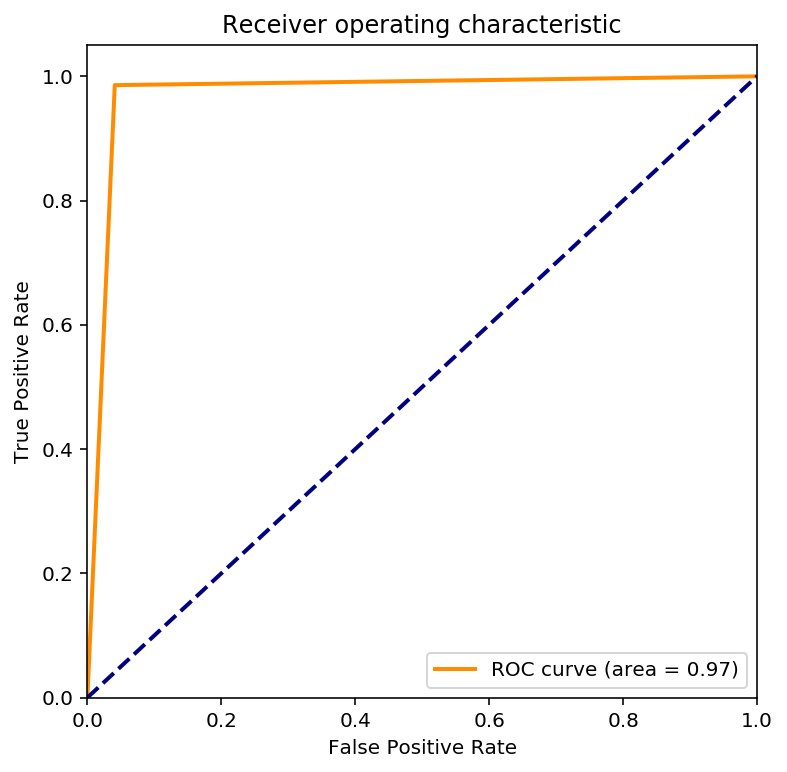

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

mpl.rcParams["figure.figsize"] = (6, 6)

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score

# Binarize the output
y_bin = label_binarize(y_test, classes=[0, 1])
n_classes = 1

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

So our final model has an exceptionally low false positive and false negative rate. This is great, though we're a bit far from making a Roger Ebert replacement. Thus far I've only shown you a guide on using Attention mechanisms for a basic classification task. For tasks like Natural Language Generation, Translation, or Named Entity description, we'll need to go into more nuances of attention, namely the Encoder-Decoder framework. But, that's a topic for another post.

## References
- Ilya Sutskever, Oriol Vinyals, and Quoc V. Le. ["Sequence to sequence learning with neural networks."](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf) NIPS 2014.
- Lilian Weng. "Attention? Attention!" In:lilianweng.github.io/lil-log (2018). url: http://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html.
- Dzmitry Bahdanau, Kyunghyun Cho, and Yoshua Bengio. ["Neural machine translation by jointly learning to align and translate."](https://arxiv.org/pdf/1409.0473.pdf) ICLR 2015.
- Ashish Vaswani, et al. ["Attention is all you need."](http://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf) NIPS 2017.
- ["Neural Machine Translation (seq2seq) Tutorial"](https://github.com/tensorflow/nmt)
- Denny Britz, Anna Goldie, Thang Luong, and Quoc Le. ["Massive exploration of neural machine translation architectures."](https://arxiv.org/abs/1703.03906) ACL 2017.